# Torches

New MIP challange! Suppose I have a (n,m) grid. I wish to light every single cell of it. How it works:

 1. If a giving cell has a torch, then it has maximum brightness;
 2. otherwise, its brightness is its maximum neighbor brightness minus 1. A neighbor cell is a cell that shares edges.
 3. No cell can have brightness below the minimum required.
 4. There are non-transparent blocks in the way.
 5. **FIND THE MINIMUM NUMBER OF TORCHES REQUIRED**.

In [1]:
from mip import *
import numpy as np
import matplotlib.pyplot as plt

Using Python-MIP package version 1.6.7


/opt/local/lib/pypy3/lib-python/3/importlib/_bootstrap.py:219: UserWarning: builtins.type size changed, may indicate binary incompatibility. Expected 872, got 416
  return f(*args, **kwds)


This solution has two steps:
 1. **Find the maximum neighbor brightness**: first, you need an upper bound to this value (which is obviously the max value); then you can use binary variables to specify which neighbor has the maximum. [[1]](https://math.stackexchange.com/a/3568461)
 2. **If-Then-Else**: this one is trickier, but works using lower and upper bound and two-sided restrictions. [[2]](https://math.stackexchange.com/a/2501007)

In [2]:
def neighs(i, j, n, m):
    x = list()
    
    if i > 0:
        x.append((i-1, j))
    if i < (n-1):
        x.append((i+1, j))
    if j > 0:
        x.append((i, j-1))
    if j < (m-1):
        x.append((i, j+1))
        
    return x

In [3]:
def torches(rows, cols, minv, maxv, blocks=[], verbose=True):
    m = Model()
    possibilities = [(i,j) for i in range(rows) for j in range(cols) if (i,j) not in blocks]
    nn = {(i,j): [x for x in neighs(i, j, rows, cols) if x not in blocks] for i,j in possibilities}

    level = {k: m.add_var(var_type=INTEGER, lb=minv, ub=maxv) for k in possibilities}
    torch = {k: m.add_var(var_type=BINARY) for k in possibilities}
    max_neighbor = {k: m.add_var(var_type=INTEGER, lb=minv, ub=maxv) for k in possibilities}
    which_neighbor = {(i,j,k): m.add_var(var_type=BINARY) for i,j in possibilities for k in range(len(nn[(i,j)]))}
    sol = m.add_var(lb=1)
      
    # Find max neighbor
    for i,j in possibilities:        
        for k in range(len(nn[(i,j)])):
            a, b = nn[(i,j)][k]
            m += max_neighbor[(i,j)] >= level[(a,b)]
            m += max_neighbor[(i,j)] <= level[(a,b)] + (1 - which_neighbor[(i,j,k)])*maxv
        m += xsum(which_neighbor[(i,j,k)] for k in range(len(nn[(i,j)]))) == 1
            
    # If then else
    for k in possibilities:
        m += level[k] - max_neighbor[k] + 1 >= 0
        m += level[k] - max_neighbor[k] + 1 <= 2 * torch[k]
        m += maxv - level[k] >= 0
        m += maxv - level[k] <= (1 - torch[k])*(maxv-minv)
    
    # Solution
    m += sol == xsum(torch[k] for k in possibilities)
    m.objective = sol

    greedy_sol = greedy(rows, cols, minv, maxv, blocks)
    m.start = [(m.vars[x], greedy_sol[x]) for x in range(len(greedy_sol))]
    
    m.emphasis = 2
    m.cuts = 3
    m.max_seconds = 900

    status = m.optimize()
    
    if verbose:
        if status == OptimizationStatus.OPTIMAL:
            print('optimal solution cost {} found'.format(m.objective_value))
        elif status == OptimizationStatus.FEASIBLE:
            print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
        elif status == OptimizationStatus.NO_SOLUTION_FOUND:
            print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
        elif status == OptimizationStatus.INFEASIBLE:
            print('INFEASIBLE'.format(m.objective_bound))
    return m

Initial solutions improve considerably the running time of MIP models, so I decided to implement a simple greedy algorithm:

 1. Choose a cell such that its brightness is less than the minimum value;
 2. Updates the grid brightness;
 3. Repeat until there is no cell available.

In [4]:
def greedy(rows, cols, minv, maxv, blocks):
    possibilities = [(i,j) for i in range(rows) for j in range(cols) if (i,j) not in blocks]
    nn = {(i,j): [x for x in neighs(i, j, rows, cols) if x not in blocks] for i,j in possibilities}

    init = lambda : {k:0 for k in possibilities}
    level = init()
    torch = init()
    remains = set(k for k in possibilities if level[k] <= minv)

    def update(k):
        if level[k] > minv:
            for l in nn[k]:
                if level[l] < level[k]:
                    level[l] = level[k] - 1
                    if l in remains:
                        remains.remove(l)
                    update(l)

    while len(remains) > 0:
        k = remains.pop()
        torch[k] = True
        level[k] = maxv
        update(k)

    sol = list()
    for k in possibilities:
        sol.append(level[k])
    for k in possibilities:
        sol.append(torch[k])

    maxes = {k:[level[l] for l in nn[k]] for k in nn}
    for k in possibilities:
        sol.append(max(maxes[k]))
    for k in possibilities:
        val = maxes[k]
        aux = [0 for l in nn[k]]
        aux[val.index(max(val))] = 1
        sol += aux

    obj = 0
    for k in possibilities:
        if torch[k] == 1:
            obj += 1
    sol.append(obj)

    return sol

For sake of illustration, we can plot the grid using our model solution. We'll use two plots: the first showing where are the torches; the second showing the brightness levels.

In [5]:
def plot(m, rows, cols, blocks):
    A = np.zeros((rows,cols))
    B = np.zeros((rows,cols))
    const = rows*cols-len(blocks)
    
    ind = 0
    ptr = 0
    while ind < rows*cols:
        i = ind // cols
        j = ind % cols
    
        if (i,j) in blocks:
            A[i][j] = -1
            B[i][j] = 0
            
        else:
            A[i][j] = m.vars[ptr+const].x
            B[i][j] = m.vars[ptr].x
            ptr += 1
            
        ind += 1
        
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    axes[0].imshow(A)
    axes[0].set_title("Torches")

    axes[1].imshow(B)
    plt.title("Lights")
    
    for i in range(rows):
        for j in range(cols):
            if (i,j) not in blocks:
                text = axes[1].text(j, i, int(B[i][j]), ha="center", va="center", color="w")
    
    plt.show()

Testing time! I will use random blocks to exemplify, so check the function below. It chooses (most of the time) the desired number of cells to be blocks, ensuring that no single empty cell has only blocks as its neighbors.

Let's run our model for 10 minutes to check if it improves our greedy solution:

In [6]:
def random_blocks(n, rows, cols):
    blocks = set()
    fix = list()
    base = [(i,j) for i in range(rows) for j in range(cols)]
    nn = {(i,j): neighs(i, j, rows, cols) for i,j in base}

    while len(blocks) < n or len(fix) > 0:
        blocks.add((np.random.randint(rows), np.random.randint(cols)))
        fix = [k for k in base if len([x for x in nn[k] if x not in blocks]) == 0 and k not in blocks]
        for k in fix:
            blocks.add(k)
            
    return blocks

In [7]:
rows, cols = 20, 20
minv, maxv = 8, 14
nblocks = 100
blocks = random_blocks(nblocks, rows, cols)
print("Actual number of blocks:", len(blocks))
print("Greedy solution cost:", greedy(rows, cols, minv, maxv, blocks)[-1])

Actual number of blocks: 100
Greedy solution cost: 24


optimal solution cost 15.0 found


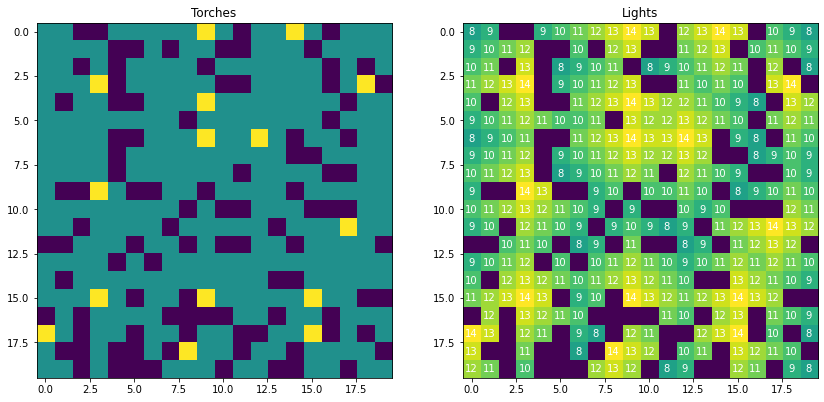

In [8]:
m = torches(rows, cols, minv, maxv, blocks)
plot(m, rows, cols, blocks)

And it did!